In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [100]:

# 准备数据集
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 将图像大小调整为32x32
    transforms.ToTensor()  # 将图像转换为张量并归一化
])


In [89]:
combined_dataset = datasets.ImageFolder('/Users/fengqiuyi/Desktop/GAN/cats-faces-64x64-for-generative-models', transform=transform)

In [101]:

# 创建数据加载器
batch_size = 64
data_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)


In [102]:

# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),  # 输入图像大小为32x32，3通道
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)  # 压缩成32维的潜在表示
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 32 * 32 * 3),  # 输出图像大小同输入
            nn.Sigmoid()  # 将输出限制在0到1之间
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 将输入展平成向量
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 3, 32, 32)  # 将输出恢复成图像形状
        return x


In [103]:

# 实例化自编码器模型
autoencoder = Autoencoder()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


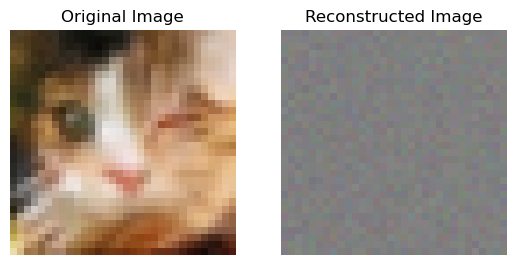

Epoch [1/10], Loss: 0.0276


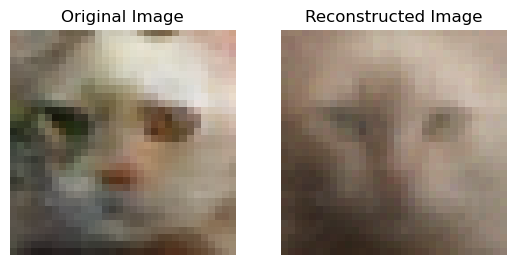

Epoch [2/10], Loss: 0.0161


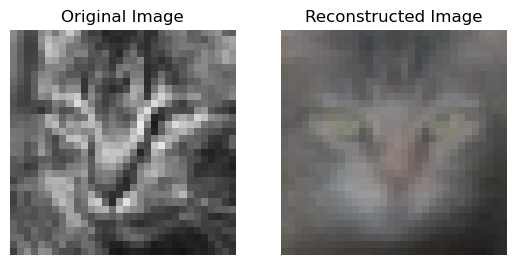

Epoch [3/10], Loss: 0.0140


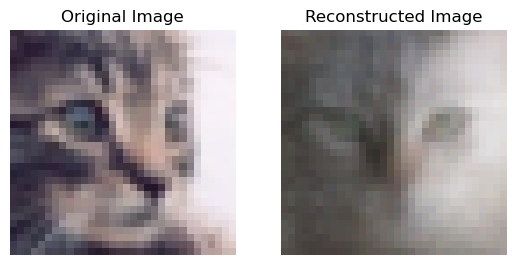

Epoch [4/10], Loss: 0.0130


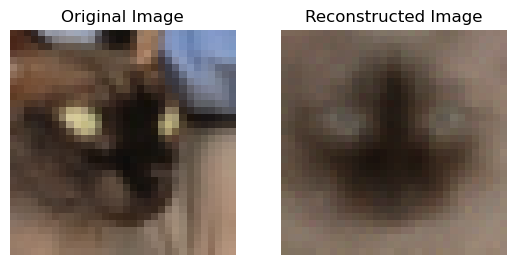

Epoch [5/10], Loss: 0.0123


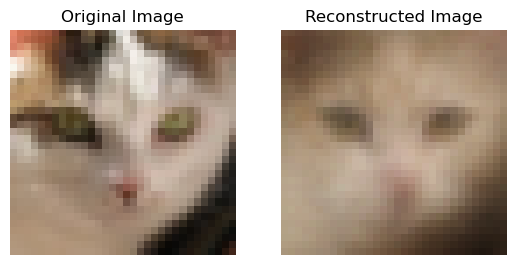

Epoch [6/10], Loss: 0.0118


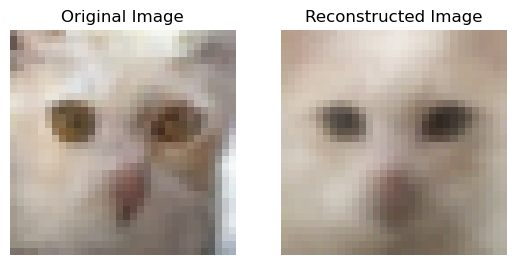

Epoch [7/10], Loss: 0.0113


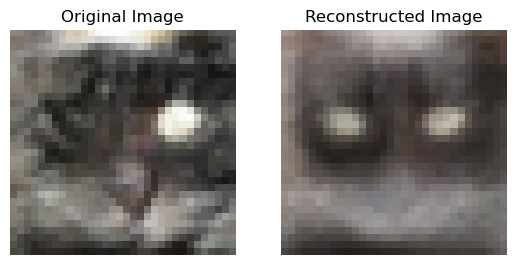

Epoch [8/10], Loss: 0.0111


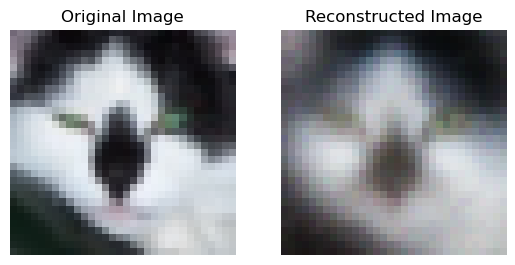

Epoch [9/10], Loss: 0.0108


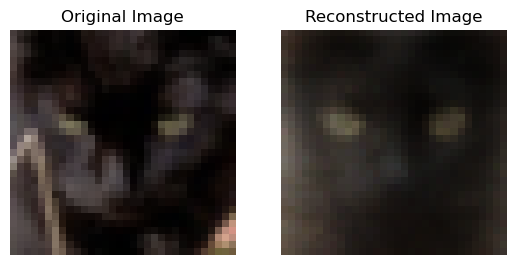

Epoch [10/10], Loss: 0.0107


In [117]:

# 训练自编码器模型
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i,data in enumerate(data_loader):
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            # 可视化重构图像
        if i == 0:
            # 取第一个batch的图像
            original_img = inputs[0].numpy()
            reconstructed_img = outputs[0].detach().numpy()
            
            # 可视化原始图像
            plt.subplot(1, 2, 1)
            plt.imshow(np.transpose(original_img, (1, 2, 0)))
            plt.title('Original Image')
            plt.axis('off')
            
            # 可视化重构图像
            plt.subplot(1, 2, 2)
            plt.imshow(np.transpose(reconstructed_img, (1, 2, 0)))
            plt.title('Reconstructed Image')
            plt.axis('off')
            
            plt.show()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(data_loader)))


In [104]:

# 提取特征
encoded_features = []
labels=[]
for data in data_loader:
    inputs, label = data
    features = autoencoder.encoder(inputs.view(inputs.size(0), -1)).detach().numpy()  # 使用detach()方法分离张量
    encoded_features.append(features)
    labels.append(label)
encoded_features = np.concatenate(encoded_features, axis=0)
labels = np.concatenate(labels, axis=0)

In [105]:

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(encoded_features, labels, test_size=0.2, random_state=42)


In [106]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, log_loss

In [107]:
params = [1,2,3,4,5,6,7]
accuracys=[]
precisions=[]
f1s=[]
auc_rocs=[]
loglosses=[]
test_scores = []
for param in params:
    clf = AdaBoostClassifier(n_estimators=param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # 计算各种指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)

    accuracys.append(accuracy)
    precisions.append(precision)
    f1s.append(f1)
    auc_rocs.append(auc_roc)
    loglosses.append(logloss)
    # 打印各种指标
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("AUC-ROC:", auc_roc)
    print("Log Loss:", logloss)
    print('-----------------------')

/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.6124271844660194
Precision: 0.6124271844660194
F1 Score: 0.7596339113680154
AUC-ROC: 0.5
Log Loss: 13.969540226151036
-----------------------
Accuracy: 0.6322330097087379
Precision: 0.6723194748358862
F1 Score: 0.7218795888399413
AUC-ROC: 0.589563718432426
Log Loss: 13.255665926017066
-----------------------


/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.636504854368932
Precision: 0.6454174228675136
F1 Score: 0.7524464427400158
AUC-ROC: 0.5594815185221426
Log Loss: 13.101693037752876
-----------------------
Accuracy: 0.6388349514563106
Precision: 0.6428256070640177
F1 Score: 0.7579385736595523
AUC-ROC: 0.5563253965127465
Log Loss: 13.01770782597241
-----------------------


/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.6477669902912622
Precision: 0.6599045346062052
F1 Score: 0.7529956427015251
AUC-ROC: 0.5813683486186069
Log Loss: 12.695764514147283
-----------------------


/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.6477669902912622
Precision: 0.6599045346062052
F1 Score: 0.7529956427015251
AUC-ROC: 0.5813683486186069
Log Loss: 12.695764514147283
-----------------------


/Users/fengqiuyi/anaconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.6574757281553398
Precision: 0.6726279185295578
F1 Score: 0.7543175487465181
AUC-ROC: 0.5991358112547225
Log Loss: 12.345826131728671
-----------------------


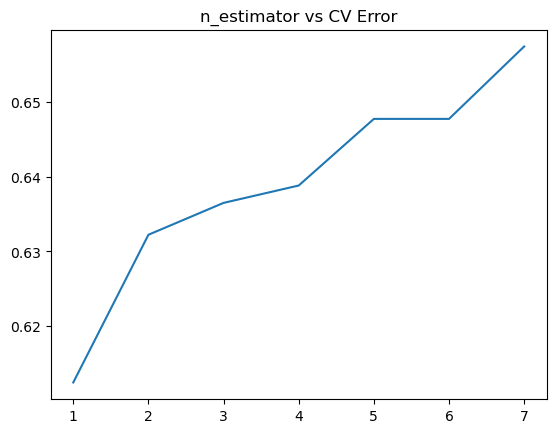

In [108]:
plt.plot(params, accuracys)
plt.title("accuracy");

In [109]:
from xgboost import XGBClassifier

In [110]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, log_loss
# from sklearn.model_selection import train_test_split

In [113]:
params = [1,2,3,4,5,6,7,10]
accuracys=[]
precisions=[]
f1s=[]
auc_rocs=[]
loglosses=[]
for param in params:
    clf = XGBClassifier(max_depth=param)
    clf.fit(X_train, y_train)
    # test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    # test_scores.append(np.mean(test_score))
    y_pred = clf.predict(X_test)

    # 计算各种指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)

    accuracys.append(accuracy)
    precisions.append(precision)
    f1s.append(f1)
    auc_rocs.append(auc_roc)
    loglosses.append(logloss)
    # 打印各种指标

    print("Precision:", precision)
    print("F1 Score:", f1)
    print("AUC-ROC:", auc_roc)
    print("Log Loss:", logloss)
    print('-----------------------')

Accuracy: 0.7046601941747572
Precision: 0.7097354225533008
F1 Score: 0.7841634738186463
AUC-ROC: 0.654949086505287
Log Loss: 10.64512559317421
-----------------------
Accuracy: 0.7532038834951457
Precision: 0.7608755888057633
F1 Score: 0.8120656513381636
AUC-ROC: 0.7191378635520882
Log Loss: 8.895433681081146
-----------------------
Accuracy: 0.7784466019417475
Precision: 0.7918237170194259
F1 Score: 0.8271997576859004
AUC-ROC: 0.7530825760589027
Log Loss: 7.985593886792752
-----------------------
Accuracy: 0.7984466019417475
Precision: 0.8106283029947152
F1 Score: 0.8417682926829269
AUC-ROC: 0.7761250147727288
Log Loss: 7.264720819010409
-----------------------
Accuracy: 0.8198058252427185
Precision: 0.8290952099349498
F1 Score: 0.8580171358629131
AUC-ROC: 0.799725322553795
Log Loss: 6.49485637768946
-----------------------
Accuracy: 0.8376699029126213
Precision: 0.8392857142857143
F1 Score: 0.8727549467275495
AUC-ROC: 0.8169771693037311
Log Loss: 5.850969754039212
-------------------

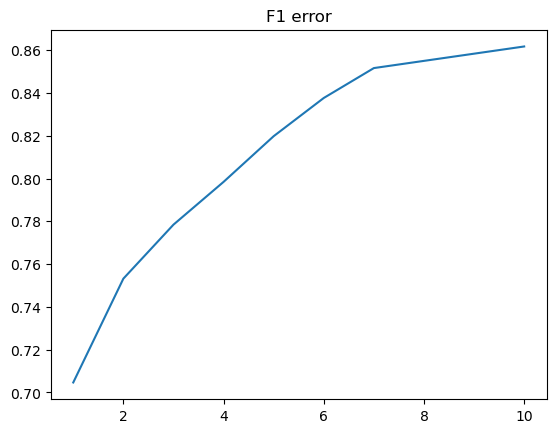

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params,accuracys)
plt.title("accuracy");